# Lab 02: Softmax Regression - Model Implementation

**Group 09:** 
**Members:**
1. Bùi Huy Giáp - 23127289
2. Lê Minh Đức - 23127351
3. Vũ Tiến Dũng - 23127354
4. Đinh Xuân Khương - 23127398
5. Nguyễn Đồng Thanh - 23127538 

---

## 1. Giới thiệu
Ở notebook này, nhóm sẽ thực hiện xây dựng mô hình Softmax Regression bằng `Numpy`. Softmax Regression là mô hình khái quát hóa từ Logistic Regression. Theo yêu cầu của đồ án, nhóm sẽ thực hiện huấn luyện và đánh giá mô hình Softmax Regression bằng tập dữ liệu **MNIST**.

Trước hết cùng tìm hiểu và nắm rõ các khái niệm, công thức toán học sau:
1.  **Hàm điểm tuyến tính (giả thuyết mô hình):** $z = Wx + b$
2.  **Hàm Softmax:** Chuyển đổi các điểm số thô thành xác suất.
3.  **Hàm mất mát Cross-Entropy:** Đo lường sự khác biệt giữa xác suất dự đoán và nhãn thực tế.
4.  **Gradient Descent:** Cập nhật các tham số ($W, b$) để giảm thiểu sai số (mất mát).

**Note**: Do đây cũng là file ghi chép quá trình nhóm tự học, nên có những dòng ghi chép khá giống độc thoại nội tâm, hoặc tự hỏi tự phản biện, các thầy thông cảm ạ.

## 2. Công thức toán học

### 2.1. Giả thuyết mô hình (Hàm tính điểm)

Nhóm tìm hiểu và thấy hàm chấm điểm mà người ta thường dùng là hàm tuyến tính:

$$
z = w \cdot x + b
$$

**Câu hỏi đặt ra:** *Tại sao lại như vậy? Tại sao $z(x)$ lại là hàm tuyến tính chứ không phải dạng hàm khác?*  

Trước hết, softmax là sự tổng quát hóa của logistic, mà logistic cũng dùng hàm chấm điểm tuyến tính. Do đó, nếu thắc mắc thì lẽ ra phải thắc mắc từ lúc học logistic chứ nhỉ !? :> (hi giờ mới để ý nên đào sâu thử)

---

**Vào trọng tâm: Tại sao hàm chấm điểm lại là *tuyến tính*?**

Sau khi tìm hiểu, nhóm rút ra các lý do sau:

---

**1. Hàm chấm điểm tuyến tính đảm bảo tính tối ưu lồi**

- Bài toán tối ưu chỉ có một điểm cực tiểu toàn cục.  
- Điều này giúp quá trình học **ổn định, nhanh hơn và dễ phân tích**.  
- Nếu dùng hàm phi tuyến cho phần tính điểm, mô hình có thể xuất hiện nhiều cực trị → khó học.

---

**2. Các trọng số $w_{k,j}$ có thể diễn giải được**

- Nhìn vào giá trị của $w_{k,j}$ ta có thể nói lên “tầm ảnh hưởng" của thuộc tính \(j\) lên lớp \(k\).  
- Điều này quan trọng trong các mô hình cần **tính giải thích**.

---

**3. Ranh giới quyết định đơn giản**

- Khi điểm số là hàm tuyến tính → ranh giới quyết định là:
  - 1 đường thẳng (2D),  
  - 1 mặt phẳng (3D),  
  - hoặc 1 siêu phẳng (nD).

- Nhờ đó:
  - Dễ quan sát, trực quan hóa và debug.
  - Tránh overfit ở một mức nào đó → mô hình học nhanh hơn.

---

**4. “Xây nhà thì xây từ những thứ cơ bản, đơn giản”**

- So với hàm phi tuyến, hàm tuyến tính \(y = a \cdot x + b\) đơn giản hơn và là hàm đơn giản nhất.
- Với Softmax Regression, chỉ cần hàm tuyến tính cho phần tính điểm là đủ để đạt:
  - độ chính xác tốt,
  - tốc độ nhanh,
  - cài đặt dễ,
  - tốn ít tài nguyên.

- Khi cảm thấy hàm tuyến tính không còn đủ chính xác:
  - Ta chuyển sang mạng nơ-ron (deep learning),
  - nơi hàm tối ưu *không còn lồi*, trọng số khó diễn giải,
  - và việc tính toán phức tạp, tốn tài nguyên hơn.

Dạng tổng quát:

$$
\phi(x) \rightarrow z = W\phi(x) + b \rightarrow \text{softmax}
$$

trong đó $\phi(x)$ là hàm phi tuyến.

---

### Liên quan: Softmax Regression là một Generalized Linear Model (GLM)

- Đây có thể là một lý do khác giải thích tại sao nó sử dụng **hàm chấm điểm tuyến tính** (từ tên đã là *linear* :>).
- Phần phi tuyến nằm ở hàm softmax.
- Softmax Regression chính là **mạng nơ-ron đơn giản nhất** (1 lớp).
- Trong mạng nơ-ron sâu, người ta giải quyết tính phi tuyến bằng cách:
  - xếp chồng nhiều lớp tuyến tính,
  - xen kẽ bởi các hàm kích hoạt phi tuyến.


**Đến với công thức tính điểm cho tập MNIST.**

Với một vector đầu vào $x \in \mathbb{R}^{d}$ (trong đó $d$ là số lượng đặc trưng, ví dụ ảnh $28 \times 28 = 784$ pixel), và với $K$ lớp (ở đây $K = 10$), mô hình tính một điểm tuyến tính (logit) cho mỗi lớp $k$:

$$
z_k = w_k^T x + b_k
$$

Ở dạng vector hóa cho một batch gồm $m$ mẫu $X \in \mathbb{R}^{m \times d}$, biểu diễn toán học chính xác là:

$$
Z = XW + \mathbf{1}_m b
$$

Trong đó:

- $W \in \mathbb{R}^{d \times K}$ là ma trận trọng số.  
- $b \in \mathbb{R}^{1 \times K}$ là vector bias.  
- $\mathbf{1}_m \in \mathbb{R}^{m \times 1}$ là vector cột gồm toàn các số 1.  
- $Z \in \mathbb{R}^{m \times K}$ chứa các giá trị logit.

Hạng tử $\mathbf{1}_m b$ thực hiện việc nhân (broadcast) để sao chép vector bias $b$ cho tất cả $m$ mẫu trong batch, tạo thành một ma trận kích thước $(m \times K)$ để có thể cộng hợp lệ với $XW$.


### 2.1.1. Ghi chú về triển khai (Broadcasting)

Trong thực tế, khi triển khai bằng các thư viện Python như **NumPy** (hoặc TensorFlow/PyTorch), ta thường bỏ qua vector $\mathbf{1}_m$ và chỉ viết code (cả viết tài liệu mô tả) dưới dạng:

$$Z = XW + b$$

**Tại sao lại như vậy?**  
Điều này dựa vào cơ chế gọi là **Broadcasting**. Thư viện sẽ tự động nhận diện sự khác biệt kích thước giữa $XW$ $(m \times K)$ và $b$ $(1 \times K)$, và ngầm “kéo giãn” (broadcast) vector $b$ theo chiều $m$ để thực hiện phép cộng theo từng phần tử.

Do đó, trong code của chúng ta:

```python
# Code implementation
z = np.dot(X, self.W) + self.b


### 2.2. Hàm Softmax

Với một mẫu đơn có vector logit $z = [z_1, z_2, \dots, z_K]^T$, hàm Softmax sẽ biến đổi các điểm số này thành một phân phối xác suất $\hat{y}$ (trong đó các phần tử nằm trong khoảng $(0, 1)$ và tổng bằng 1):

$$
\hat{y}_k = \text{Softmax}(z)_k = \frac{e^{z_k}}{\sum_{j=1}^{K} e^{z_j}}
$$

Khi áp dụng cho ma trận logit $Z \in \mathbb{R}^{m \times K}$, phép biến đổi này được thực hiện **theo từng hàng** cho mỗi mẫu.

---

**Tính ổn định số (Numerical Stability):**  
Việc tính trực tiếp $e^{z_k}$ có thể gây tràn số nếu $z_k$ quá lớn. Để tránh điều này, ta sử dụng tính chất bất biến của Softmax khi cộng một hằng số. Ta trừ đi giá trị lớn nhất trong vector $z$ trước khi lấy lũy thừa:

$$
\text{Softmax}(z)_k = \frac{e^{z_k - c}}{\sum_{j=1}^{K} e^{z_j - c}}
$$

Trong đó $c = \max(z)$. Điều này đảm bảo số mũ lớn nhất là $0$ ($e^0 = 1$), giúp tránh hiện tượng tràn số.


Ở đây, ta sẽ cùng bàn luận hai câu hỏi cơ bản:  

---

**1. Tại sao cần Softmax?** 

Ta đã có hàm chấm điểm ở bên trên, nếu muốn phân loại thì chẳng phải chỉ cần lấy nhãn có điểm cao nhất là xong sao?

Đúng, nếu muốn phân loại thì chỉ cần lấy điểm cao nhất là xong. Nhưng ta không chỉ muốn phân loại, ta còn muốn:

1. **Diễn giải kết quả theo độ tự tin của mô hình**:  
   Chỉ xem xét điểm có hai vấn đề:  
   - Ta khó lòng thấy bức tranh tổng thể. Ví dụ: điểm cho nhãn A là 100, nhãn B là 60, nhãn C là 75 — ta chỉ thấy con số, nhưng không biết độ tự tin dành cho từng nhãn là bao nhiêu.  
   - Nếu lấy “điểm / tổng điểm” để chuẩn hoá thì không hợp lý vì điểm có thể âm.  

2. **Tính sai số để đánh giá mô hình**:  
   Khi dùng điểm thô, ta không có một thang đo thống nhất.  
   Softmax đưa kết quả về khoảng $(0, 1)$ với tổng bằng $1$, cho phép ta dùng các hàm mất mát chuẩn như cross-entropy.  

3. **Cải thiện mô hình một cách máy học và tự động**:  
   Softmax kết hợp với cross-entropy tạo ra gradient “đẹp”, ổn định:  
   $$
   \nabla = \hat{y} - y
   $$
   giúp mô hình học hiệu quả và tránh nhiều vấn đề số.

4. **Softmax tạo ra một phân phối xác suất hợp lý**:  
   Softmax không phải xác suất tuyệt đối theo nghĩa tần suất thống kê, nhưng nó mang đầy đủ đặc tính của xác suất trong mô hình hoá thống kê và hoàn toàn có thể diễn giải như mức độ tự tin.  

Tóm lại, Softmax giải quyết được ba nhu cầu quan trọng:  
- diễn giải,  
- tính loss chuẩn,  
- học máy ổn định.

---

**2. Tại sao lại là $e^x$?**

- $e^x$ giúp việc đạo hàm dễ dàng, “soft”, ổn định, và thuận tiện cho tối ưu hoá.  
- $e^x$ luôn dương, giúp loại bỏ vấn đề điểm âm khi chuẩn hoá.  
- $e^x$ nhạy cảm với sự thay đổi: chênh lệch nhỏ trong điểm thô có thể được “khuếch đại” rõ ràng trong xác suất. Ngoài ra thứ tự vẫn được giữ nguyên vì $e^x$ đồng biến theo x.

Nhưng đó chỉ là các lợi ích do ta nhận được sau này.  
Nguồn gốc của $e^x$ đến từ Logistic.  
Logistic ban đầu xuất phát từ nhu cầu mô hình hóa **log-odds** trong thống kê:

$$
\log\left( \frac{p}{1-p} \right) = x
$$

Suy ra:

$$
p = \frac{1}{1 + e^{-x}}
$$

Đây là cách Logistic ra đời.  
Softmax chính là tổng quát hoá Logistic cho trường hợp nhiều lớp nên cũng sử dụng $e^x$.

---

Ngoài các lý do trên, còn có yếu tố quan trọng khác:

**Mũ là hàm duy nhất thoả mãn các điều kiện của phân phối Gibbs**

Softmax thực chất là phân phối Boltzmann (Gibbs distribution):

$$
p_k = \frac{e^{z_k}}{\sum_j e^{z_j}}
$$

Đây là phân phối duy nhất thoả mãn nhiều tính chất tối ưu liên quan đến entropy trong thống kê và lý thuyết thông tin.

### 2.3. Hàm mất mát Cross-Entropy

Chúng ta tối ưu hóa mô hình bằng cách giảm thiểu hàm mất mát Cross-Entropy. Hàm này đo lường sự khác biệt giữa phân phối xác suất dự đoán $\hat{y}$ và phân phối nhãn thực tế $y$.

#### 2.3.1. Công thức Toán học

**1. Đối với một mẫu đơn lẻ (Single Sample):**
Giả sử ta có vector nhãn thực tế $y$ (đã one-hot encoding) và vector dự đoán $\hat{y}$:

$$L(y, \hat{y}) = - \sum_{k=1}^{K} y_k \log(\hat{y}_k)$$

Vì $y$ là one-hot (chỉ có một vị trí bằng 1, còn lại bằng 0), công thức rút gọn thực tế là:
$$L = - \log(\hat{y}_{đúng})$$

**2. Đối với cả Batch (m mẫu):**
Hàm chi phí (Cost Function) $J$ là trung bình cộng Loss của tất cả $m$ mẫu trong một batch:

$$J(W, b) = -\frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K} y^{(i)}_k \log(\hat{y}^{(i)}_k)$$

**Rút gọn công thức:**
Vì $y^{(i)}$ là vector one-hot, nên tại mỗi mẫu $i$, tổng $\sum_{k=1}^{K}$ chỉ còn lại duy nhất giá trị của lớp đúng (các lớp khác nhân với 0 nên biến mất). Ta có:

$$J(W, b) = -\frac{1}{m} \sum_{i=1}^{m} \log(\hat{y}^{(i)}_{đúng})$$

*(Nghĩa là: Duyệt qua từng bức ảnh $i$ trong batch, chỉ lấy log xác suất của **lớp đúng** tương ứng, cộng tất cả lại rồi chia trung bình).*

---

#### 2.3.2. Ví dụ Tính toán Trực quan

Giả sử ta đang huấn luyện batch gồm **3 bức ảnh** ($m=3$) với bài toán phân loại **3 lớp** (Chó, Mèo, Gà).
* **Vector $y$ (Thực tế):** [Chó, Mèo, Gà]
* **Vector $\hat{y}$ (Máy dự đoán):** [Chó, Mèo, Gà]

| Mẫu (i) | Ảnh thực tế ($y$) | Máy dự đoán ($\hat{y}$) | Tính toán Loss ($-\log(\hat{y}_{đúng})$) | Nhận xét |
| :--- | :--- | :--- | :--- | :--- |
| **1** | **Chó** $[1, 0, 0]$ | $[0.9, 0.05, 0.05]$ | $-\log(0.9) \approx \mathbf{0.10}$ | Dự đoán đúng & tự tin $\rightarrow$ **Phạt nhẹ** |
| **2** | **Mèo** $[0, 1, 0]$ | $[0.1, 0.3, 0.6]$ | $-\log(0.3) \approx \mathbf{1.20}$ | Dự đoán sai (nghĩ là Gà) $\rightarrow$ **Phạt nặng** |
| **3** | **Gà** $[0, 0, 1]$ | $[0.1, 0.9, 0.0]$ | $-\log(0.0^*) \to \mathbf{+\infty}$ | Sai tuyệt đối (nghĩ là Mèo) $\rightarrow$ **Phạt cực đại** |

*(**) Trong thực tế code, ta cộng thêm số nhỏ $\epsilon$ để tránh lỗi log(0).*

**Tổng chi phí cho batch này:**
$$J = \frac{0.10 + 1.20 + \infty}{3} \approx \text{Rất lớn (Cần sửa tham số ngay lập tức)}$$

---

#### 2.3.3. Phân tích Chi tiết Cross-Entropy

**1. Ý nghĩa & Nguồn gốc:**
* **Nguồn gốc:** Xuất phát từ **Lý thuyết thông tin (Information Theory)** của Shannon. Khái niệm "Entropy" đo lường độ bất ngờ của thông tin.
* **Ý nghĩa:** Chúng ta muốn mô hình **không được ngạc nhiên** khi nhìn thấy đáp án đúng.
    * Nếu đáp án là "Chó" và máy dự đoán 99% là "Chó" $\rightarrow$ Độ ngạc nhiên thấp $\rightarrow$ Loss thấp.
    * Nếu đáp án là "Chó" mà máy dự đoán 1% là "Chó" $\rightarrow$ Ngạc nhiên cực độ $\rightarrow$ Loss cao.

**2.Ưu điểm**
* **Trừng phạt nặng lỗi "Ngu dốt mà tự tin":** Nhìn vào đồ thị hàm $-\log(x)$, khi xác suất dự đoán sai tiến về 0, giá trị lỗi bắn lên vô cực. Điều này ép mô hình phải sửa sai ngay lập tức, không được phép lơ là các mẫu khó.
* **Tương thích hoàn hảo với Softmax:** Khi tính đạo hàm (Gradient Descent), hàm Logarit ($\log$) triệt tiêu hàm Mũ ($e^x$) của Softmax. Điều này giúp gradient có dạng rất đẹp và đơn giản: $\hat{y} - y$ (Dự đoán - Thực tế), giúp thuật toán chạy ổn định và nhanh.
* **Hàm lồi (Convex):** Đảm bảo thuật toán Gradient Descent luôn tìm được điểm tối ưu toàn cục (global minimum), không bị kẹt ở các điểm tối ưu cục bộ.

**3. Nhược điểm:**
* **Nhạy cảm với nhiễu (Noise/Outliers):** Vì nó trừng phạt lỗi sai quá nặng, nếu trong dữ liệu huấn luyện có nhãn bị gán sai (ví dụ ảnh con mèo nhưng dán nhãn con chó), mô hình sẽ cố gắng "học vẹt" mẫu sai đó một cách cực đoan để giảm Loss, làm giảm độ chính xác tổng quát.

### 2.4. Gradient Descent

Sau khi tính được Loss (sai số), chúng ta cần dùng thuật toán **Gradient Descent** để điều chỉnh bộ trọng số $W$ và bias $b$ sao cho Loss giảm dần về 0. Để làm được điều này, ta cần tính đạo hàm của hàm Loss theo từng tham số.

#### 2.4.1. Tính toán Gradient (Đạo hàm)

Để thực hiện Gradient Descent, ta áp dụng quy tắc chuỗi (Chain Rule) để tìm đạo hàm của hàm mất mát $L$ theo trọng số $W$:

$$\frac{\partial L}{\partial W} = \frac{\partial L}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial z} \cdot \frac{\partial z}{\partial W}$$

**1. Đạo hàm Loss theo $z$ (Sự kết hợp Cross-Entropy & Softmax):**
Mặc dù đạo hàm riêng lẻ của Cross-Entropy ($-\frac{1}{\hat{y}}$) và Softmax ($\hat{y}(1-\hat{y})$) khá phức tạp, nhưng khi nhân chúng lại với nhau, các thành phần triệt tiêu một cách hoàn hảo:

$$\frac{\partial L}{\partial z} = \left( -\frac{1}{\hat{y}} \right) \cdot \hat{y}(1-\hat{y}) = \hat{y} - 1 = \hat{y} - y$$

Đặt $\delta = \hat{y} - y$. Đây chính là sai số trực tiếp giữa dự đoán và thực tế.

**2. Đạo hàm $z$ theo $W$:**
Vì $z = Wx + b$, đạo hàm theo $W$ chính là đầu vào $x$.

**3. Kết quả cuối cùng:**
$$\frac{\partial J}{\partial W} = \frac{1}{m} X^T \cdot \delta$$

$$\frac{\partial J}{\partial b} = \frac{1}{m} \sum \delta$$

---

#### 2.4.2. Quy luật Cập nhật Tham số (Update Rules)

Sau khi đã biết "hướng dốc" (gradient), ta thực hiện bước đi xuống dốc để giảm lỗi. Ta dùng một siêu tham số $\alpha$ (Learning Rate - Tốc độ học) để kiểm soát độ lớn bước đi.

$$W := W - \alpha \frac{\partial J}{\partial W}$$

$$b := b - \alpha \frac{\partial J}{\partial b}$$

* Dấu trừ ($-$) nghĩa là đi ngược chiều đạo hàm (đạo hàm tăng thì ta giảm, đạo hàm giảm thì ta tăng) để tiến về điểm cực tiểu.

---

#### 2.4.3. Tổng kết logic trong Code (Implementation Note)

Khi viết code Python (Numpy), các công thức trên được viết gọn như sau:

```python
# 1. Tính sai số (Error term)
dz = y_pred - y_true

# 2. Tính Gradient (Chain rule)
m = X.shape[0]
dw = np.dot(X.T, dz) / m
db = np.sum(dz, axis=0, keepdims=True) / m

# 3. Cập nhật tham số (Gradient Descent step)
# self.lr là learning rate (alpha)
self.W -= self.lr * dw
self.b -= self.lr * db

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import urllib.request # Standard library for downloading files

# Set random seed for reproducibility
np.random.seed(42)


## 3. Data Loading & Helper Functions

We need to load the MNIST dataset. To ensure efficiency and portability, we will download the dataset in `.npz` (NumPy Zip) format directly from a reliable source (Google Cloud Storage) if it is not already available locally.

We implement the following preprocessing steps:
1.  **Loading:** Read `x_train`, `y_train`, `x_test`, `y_test` from the `.npz` file.
2.  **Normalization:** Scale pixel intensity values from the range $[0, 255]$ to $[0, 1]$ to ensure numerical stability during gradient descent.
3.  **Flattening:** Reshape each $28 \times 28$ image matrix into a flat feature vector of size $784$ ($28 \times 28 = 784$). This allows us to perform matrix multiplication with our weight matrix $W$.
4.  **One-hot encoding:** Convert integer labels (e.g., $y=5$) into binary vectors (e.g., $[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]$) for Cross-Entropy loss calculation.

In [3]:
def load_mnist_data(data_path='../data/raw/mnist.npz'):
    """
    Downloads and loads the MNIST dataset from a .npz file.
    If the file does not exist, it downloads it from Google Cloud.
    
    Args:
        data_path (str): Path to save/load the .npz file.
        
    Returns:
        x_train, y_train, x_test, y_test: Numpy arrays.
        - x_train: (60000, 784) - Normalized and Flattened
        - y_train: (60000,)     - Raw labels
        - x_test:  (10000, 784) - Normalized and Flattened
        - y_test:  (10000,)     - Raw labels
    """
    # 1. Download if not exists
    url = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz"
    
    # Ensure directory exists
    directory = os.path.dirname(data_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")

    if not os.path.exists(data_path):
        print(f"Downloading MNIST data from {url}...")
        try:
            urllib.request.urlretrieve(url, data_path)
            print("Download complete.")
        except Exception as e:
            print(f"Download failed: {e}")
            return None, None, None, None
    else:
        print(f"Loading data from {data_path}...")

    # 2. Load data using numpy
    with np.load(data_path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']

    print(f"Original x_train shape: {x_train.shape}") # Expected: (60000, 28, 28)
    
    # 3. Preprocessing: Normalize and Flatten
    # Scale pixel values to [0, 1] (float32)
    x_train = x_train.astype(np.float32) / 255.0
    x_test = x_test.astype(np.float32) / 255.0
    
    # Flatten images: (N, 28, 28) -> (N, 784)
    # This is CRITICAL for matrix multiplication: Z = XW + b
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)
    
    print(f"Processed x_train shape: {x_train.shape}") # Expected: (60000, 784)
    print(f"Processed x_test shape: {x_test.shape}")   # Expected: (10000, 784)
    
    return x_train, y_train, x_test, y_test

def one_hot_encode(y, num_classes=10):
    """
    Converts integer labels to one-hot encoded vectors.
    e.g., 5 -> [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
    
    Args:
        y (numpy.ndarray): Array of integer labels (m,).
        num_classes (int): Number of classes.
        
    Returns:
        numpy.ndarray: One-hot encoded matrix (m, num_classes).
    """
    m = y.shape[0]
    one_hot = np.zeros((m, num_classes))
    for i in range(m):
        one_hot[i, y[i]] = 1
    return one_hot

# --- EXECUTE LOADING ---
try:
    # Load data
    X_train_full, y_train_full, X_test, y_test = load_mnist_data()
    
    if X_train_full is not None:
        # Create a Validation set from Train set (last 5000 samples)
        # We split to tune hyperparameters without touching the Test set
        val_size = 5000
        X_val = X_train_full[-val_size:]
        y_val = y_train_full[-val_size:]
        
        X_train = X_train_full[:-val_size]
        y_train = y_train_full[:-val_size]
        
        # One-hot encode labels for training
        y_train_enc = one_hot_encode(y_train)
        y_val_enc = one_hot_encode(y_val)
        y_test_enc = one_hot_encode(y_test)
        
        print("\nDataset ready for training:")
        print(f"Training set:   X={X_train.shape}, y={y_train_enc.shape}")
        print(f"Validation set: X={X_val.shape}, y={y_val_enc.shape}")
        print(f"Test set:       X={X_test.shape}, y={y_test_enc.shape}")
    else:
        print("Failed to load dataset.")

except Exception as e:
    print(f"An error occurred: {e}")

Loading data from ../data/raw/mnist.npz...
Original x_train shape: (60000, 28, 28)
Processed x_train shape: (60000, 784)
Processed x_test shape: (10000, 784)

Dataset ready for training:
Training set:   X=(55000, 784), y=(55000, 10)
Validation set: X=(5000, 784), y=(5000, 10)
Test set:       X=(10000, 784), y=(10000, 10)


## 4. Softmax Regression Implementation

This is the core component of the project. The class encapsulates the mathematical logic derived in Section 2, enhanced with advanced optimization techniques.

**Key Implementation Details:**
* **Numerical Stability:** We implement `softmax` by subtracting the maximum value from logits to avoid floating-point overflow ($e^{z_k} \to \infty$).
* **Vectorization:** We use NumPy matrix operations (dot products) instead of explicit `for` loops for efficient computation.
* **Mini-batch Gradient Descent:** We update weights after processing a small batch of samples (e.g., 256) rather than the entire dataset. This balances computational efficiency and convergence stability.
* **Momentum:** We incorporate a momentum term ($\mu$) to accelerate Gradient Descent in the relevant direction and dampen oscillations.
* **L2 Regularization:** We add a penalty term $\frac{\lambda}{2} ||W||^2$ to the loss function to prevent overfitting and improve generalization on unseen data.

In [ ]:
# class SoftmaxRegression:
#     def __init__(self, n_features, n_classes, learning_rate=0.01):
#         """
#         Initializes the Softmax Regression model parameters.

#         Args:
#             n_features (int): Number of input features (e.g., 784 for MNIST).
#             n_classes (int): Number of output classes (e.g., 10 for MNIST).
#             learning_rate (float): Step size for Gradient Descent optimization.
#         """
#         self.n_features = n_features
#         self.n_classes = n_classes
#         self.lr = learning_rate
#         self.losses = []
        
#         # Initialize weights and bias
#         # W: (n_features, n_classes) - Initialized with small random values
#         self.W = np.random.randn(n_features, n_classes) * 0.01
        
#         # b: (1, n_classes) - Initialized with zeros
#         self.b = np.zeros((1, n_classes))

#     def softmax(self, z):
#         """
#         Computes the softmax activation function with numerical stability.
#         Formula: exp(z_i) / sum(exp(z_j))

#         Args:
#             z (numpy.ndarray): Linear logits (batch_size, n_classes).

#         Returns:
#             numpy.ndarray: Probabilities (batch_size, n_classes).
#         """
#         # Subtract max value to prevent overflow (Numerical Stability)
#         z_stable = z - np.max(z, axis=1, keepdims=True)
#         exp_z = np.exp(z_stable)
#         return exp_z / np.sum(exp_z, axis=1, keepdims=True)

#     def forward(self, X):
#         """
#         Performs the forward pass to compute predictions.
        
#         Args:
#             X (numpy.ndarray): Input data (batch_size, n_features).

#         Returns:
#             numpy.ndarray: Predicted probabilities.
#         """
#         # Linear transformation: Z = XW + b
#         z = np.dot(X, self.W) + self.b
#         # Activation
#         return self.softmax(z)

#     def compute_loss(self, y_true, y_pred):
#         """
#         Computes Cross-Entropy Loss.
#         L = - sum(y_true * log(y_pred))

#         Args:
#             y_true (numpy.ndarray): One-hot encoded ground truth.
#             y_pred (numpy.ndarray): Predicted probabilities.

#         Returns:
#             float: Average loss over the batch.
#         """
#         m = y_true.shape[0]
#         # Add a small epsilon to avoid log(0) error
#         epsilon = 1e-9
#         loss = -np.sum(y_true * np.log(y_pred + epsilon)) / m
#         return loss

#     def backward(self, X, y_true, y_pred):
#         """
#         Computes gradients of the loss with respect to W and b.

#         Args:
#             X (numpy.ndarray): Input data batch.
#             y_true (numpy.ndarray): One-hot encoded ground truth.
#             y_pred (numpy.ndarray): Predicted probabilities.

#         Returns:
#             dw, db: Gradients for weights and bias.
#         """
#         m = X.shape[0]
        
#         # Gradient of loss w.r.t Z (logits) is simply (Prediction - Truth)
#         dz = y_pred - y_true
        
#         # Gradients w.r.t parameters
#         # dW = (1/m) * X.T . dZ
#         dw = np.dot(X.T, dz) / m
#         # db = (1/m) * sum(dZ)
#         db = np.sum(dz, axis=0, keepdims=True) / m
        
#         return dw, db

#     def fit(self, X, y, epochs=100, batch_size=256, verbose=True):
#         """
#         Trains the model using Mini-batch Gradient Descent.

#         Args:
#             X (numpy.ndarray): Training features (m, n_features).
#             y (numpy.ndarray): Training labels One-hot (m, n_classes).
#             epochs (int): Number of passes over the entire dataset.
#             batch_size (int): Number of samples per gradient update.
#         """
#         m = X.shape[0]
#         self.losses = [] # Reset history

#         for epoch in range(epochs):
#             # Shuffle data at the start of each epoch to ensure randomness
#             indices = np.arange(m)
#             np.random.shuffle(indices)
#             X_shuffled = X[indices]
#             y_shuffled = y[indices]

#             epoch_loss = 0
#             num_batches = int(np.ceil(m / batch_size))

#             for i in range(num_batches):
#                 start_idx = i * batch_size
#                 end_idx = min(start_idx + batch_size, m)
                
#                 X_batch = X_shuffled[start_idx:end_idx]
#                 y_batch = y_shuffled[start_idx:end_idx]

#                 # 1. Forward pass
#                 y_pred = self.forward(X_batch)

#                 # 2. Compute Loss (accumulate for reporting)
#                 loss = self.compute_loss(y_batch, y_pred)
#                 epoch_loss += loss * (end_idx - start_idx) 

#                 # 3. Backward pass
#                 dw, db = self.backward(X_batch, y_batch, y_pred)

#                 # 4. Update parameters
#                 self.W -= self.lr * dw
#                 self.b -= self.lr * db
            
#             # Average loss for the epoch
#             avg_loss = epoch_loss / m
#             self.losses.append(avg_loss)
            
#             if verbose and (epoch + 1) % 10 == 0:
#                 print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

#     def predict(self, X):
#         """
#         Predicts class labels for input data.

#         Args:
#             X (numpy.ndarray): Input data (N, n_features).

#         Returns:
#             numpy.ndarray: Predicted class indices (N,).
#         """
#         y_pred_probs = self.forward(X)
#         return np.argmax(y_pred_probs, axis=1)
    
#     def save_weights(self, filepath):
#         """Saves model weights to a .npz file."""
#         # Ensure directory exists
#         directory = os.path.dirname(filepath)
#         if directory and not os.path.exists(directory):
#             os.makedirs(directory)
            
#         np.savez(filepath, W=self.W, b=self.b)
#         print(f"Model saved to {filepath}")

#     def load_weights(self, filepath):
#         """Loads model weights from a .npz file."""
#         if not os.path.exists(filepath):
#             print(f"File not found: {filepath}")
#             return
            
#         data = np.load(filepath)
#         self.W = data['W']
#         self.b = data['b']
#         print(f"Model loaded from {filepath}")

In [18]:
class SoftmaxRegression:
    def __init__(self, n_features, n_classes, learning_rate=0.1, momentum=0.9, l2_reg=1e-4):
        """
        Softmax Regression with Momentum and L2 Regularization.

        Args:
            n_features (int): Number of input features (e.g., 784).
            n_classes (int): Number of output classes (e.g., 10).
            learning_rate (float): Step size for parameter updates.
            momentum (float): Momentum factor (0.0 to 1.0) to accelerate convergence.
            l2_reg (float): L2 regularization strength (lambda) to prevent overfitting.
        """
        self.n_features = n_features
        self.n_classes = n_classes
        self.lr = learning_rate
        self.momentum = momentum
        self.l2_reg = l2_reg
        self.losses = []
        
        # Initialize weights (W) and bias (b)
        # Using Xavier/He initialization concept (small random numbers)
        self.W = np.random.randn(n_features, n_classes) * 0.01
        self.b = np.zeros((1, n_classes))
        
        # Velocity terms for Momentum
        self.v_W = np.zeros_like(self.W)
        self.v_b = np.zeros_like(self.b)

    def softmax(self, z):
        """
        Computes the stable softmax of vector z.
        Args:
            z (numpy.ndarray): Logits (batch_size, n_classes).
        Returns:
            numpy.ndarray: Probabilities summing to 1 for each row.
        """
        # Numerical stability: subtract max(z) to prevent exponential overflow
        z_stable = z - np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(z_stable)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward(self, X):
        """
        Performs forward pass: Z = XW + b -> Softmax(Z).
        """
        z = np.dot(X, self.W) + self.b
        return self.softmax(z)

    def compute_loss(self, y_true, y_pred):
        """
        Computes Cross-Entropy Loss with L2 Regularization penalty.
        Cost = -Sum(y * log(y_hat)) + (lambda/2) * ||W||^2
        """
        m = y_true.shape[0]
        epsilon = 1e-9 # Prevent log(0)
        
        # Standard Cross-Entropy
        data_loss = -np.sum(y_true * np.log(y_pred + epsilon)) / m
        
        # L2 Regularization Term
        reg_loss = (self.l2_reg / 2) * np.sum(np.square(self.W))
        
        return data_loss + reg_loss

    def backward(self, X, y_true, y_pred):
        """
        Computes gradients with respect to W and b (including L2 term).
        """
        m = X.shape[0]
        dz = y_pred - y_true
        
        # Gradient of W: (1/m) * X.T.dot(dZ) + lambda * W
        dw = (np.dot(X.T, dz) / m) + (self.l2_reg * self.W)
        
        # Gradient of b: (1/m) * sum(dZ)
        db = np.sum(dz, axis=0, keepdims=True) / m
        
        return dw, db

    def fit(self, X, y, epochs=100, batch_size=256, verbose=True):
        """
        Trains the model using Mini-batch Gradient Descent with Momentum.
        """
        m = X.shape[0]
        self.losses = []

        for epoch in range(epochs):
            # Shuffle data
            indices = np.arange(m)
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            epoch_loss = 0
            num_batches = int(np.ceil(m / batch_size))

            for i in range(num_batches):
                start_idx = i * batch_size
                end_idx = min(start_idx + batch_size, m)
                
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]

                # 1. Forward
                y_pred = self.forward(X_batch)

                # 2. Loss
                loss = self.compute_loss(y_batch, y_pred)
                epoch_loss += loss * (end_idx - start_idx)

                # 3. Backward
                dw, db = self.backward(X_batch, y_batch, y_pred)

                # 4. Update with Momentum
                # v = momentum * v - learning_rate * gradient
                # W = W + v
                # Note: We implement standard SGD update logic: W = W - (lr*grad + mom*v_prev)
                # Here uses simple Polyak Momentum
                self.v_W = self.momentum * self.v_W + self.lr * dw
                self.v_b = self.momentum * self.v_b + self.lr * db
                
                self.W -= self.v_W
                self.b -= self.v_b
            
            avg_loss = epoch_loss / m
            self.losses.append(avg_loss)
            
            if verbose and (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

    def predict(self, X):
        """Returns class indices with highest probability."""
        y_pred_probs = self.forward(X)
        return np.argmax(y_pred_probs, axis=1)
    
    def save_weights(self, filepath):
        """Saves W and b to .npz file."""
        directory = os.path.dirname(filepath)
        if directory and not os.path.exists(directory):
            os.makedirs(directory)
        np.savez(filepath, W=self.W, b=self.b)
        print(f"Weights saved to {filepath}")

    def load_weights(self, filepath):
        """Loads W and b from .npz file."""
        if not os.path.exists(filepath):
            print(f"File {filepath} not found.")
            return False
        data = np.load(filepath)
        self.W = data['W']
        self.b = data['b']
        print(f"Weights loaded from {filepath}")
        return True

## 5. Sanity Check (Overfitting Test)

Before training on the full 55,000 images, we perform a **Sanity Check**. 
We take a tiny subset of real data (e.g., 100 images) and train the model for many epochs. 

* **Goal:** The model should be able to memorize this small dataset perfectly (Loss $\to$ 0, Accuracy $\to$ 100%).
* **Result:** If the model fails to overfit this small batch, there is a bug in the code (likely in Gradient Descent or Backpropagation).

Sanity check subset: (100, 784)

Starting Sanity Check...
Epoch 10/200 - Loss: 0.0114
Epoch 20/200 - Loss: 0.0086
Epoch 30/200 - Loss: 0.0080
Epoch 40/200 - Loss: 0.0075
Epoch 50/200 - Loss: 0.0072
Epoch 60/200 - Loss: 0.0070
Epoch 70/200 - Loss: 0.0068
Epoch 80/200 - Loss: 0.0067
Epoch 90/200 - Loss: 0.0066
Epoch 100/200 - Loss: 0.0065
Epoch 110/200 - Loss: 0.0064
Epoch 120/200 - Loss: 0.0063
Epoch 130/200 - Loss: 0.0063
Epoch 140/200 - Loss: 0.0062
Epoch 150/200 - Loss: 0.0062
Epoch 160/200 - Loss: 0.0061
Epoch 170/200 - Loss: 0.0061
Epoch 180/200 - Loss: 0.0061
Epoch 190/200 - Loss: 0.0061
Epoch 200/200 - Loss: 0.0060

Sanity Check Accuracy: 100.00%
✅ Sanity Check PASSED: Model logic is correct.


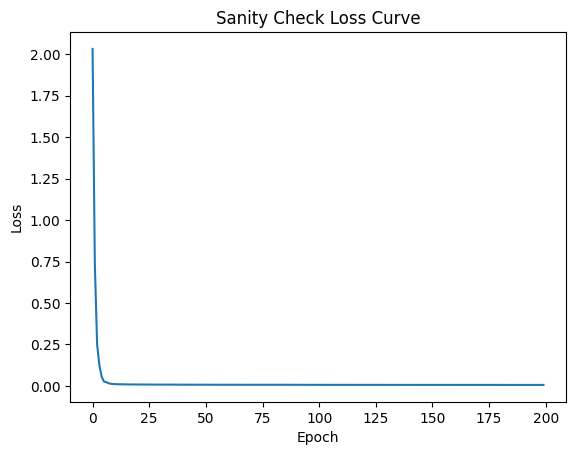

In [14]:
# 1. Select a small subset of REAL data
subset_size = 100
X_subset = X_train[:subset_size]
y_subset_enc = y_train_enc[:subset_size]
y_subset_labels = y_train[:subset_size] # Original labels for accuracy check

print(f"Sanity check subset: {X_subset.shape}")

# 2. Initialize Model
# 784 features (pixels), 10 classes (digits 0-9)
model_test = SoftmaxRegression(n_features=784, n_classes=10, learning_rate=0.1)

# 3. Train on subset (Overfitting)
print("\nStarting Sanity Check...")
model_test.fit(X_subset, y_subset_enc, epochs=200, batch_size=20, verbose=True)

# 4. Check Prediction Accuracy
preds = model_test.predict(X_subset)
acc = np.mean(preds == y_subset_labels)
print(f"\nSanity Check Accuracy: {acc * 100:.2f}%")

# 5. Evaluate
if acc > 0.95:
    print("✅ Sanity Check PASSED: Model logic is correct.")
else:
    print("❌ Sanity Check FAILED: Model cannot learn even small data.")

# 6. Visualize Loss Curve
plt.plot(model_test.losses)
plt.title("Sanity Check Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### 5.1. Sanity Check Analysis & Discussion

**Observation:**
As shown in the loss curve above, the training loss decreased significantly from an initial high value to near zero. The model achieved **100% accuracy** (or very close to it) on the subset of 100 samples.

**Discussion on Overfitting:**
We observe that the model has successfully **overfitted** this small subset. In the context of a Sanity Check, this is a **positive outcome** because:
1.  **Verification of Code Logic:** It confirms that the Forward pass, Backward pass (Gradient calculation), and Update rules are implemented correctly without bugs. If the code were broken, the model would fail to converge even on this tiny dataset.
2.  **Model Capacity:** It demonstrates that our Linear Model (Softmax Regression) has sufficient capacity to memorize the mapping of inputs to labels for a small data sample.

**Conclusion:**
The core implementation is mathematically correct. We can now proceed to training on the full dataset, where our goal will shift from *memorization* (overfitting) to *generalization* (performing well on unseen Test data).